In [268]:
import ee
import geemap
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold,train_test_split
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score,mean_absolute_percentage_error
import glob
import dask.dataframe as dd
from tpot import TPOTRegressor
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import os
from sklearn.inspection import permutation_importance

In [269]:
Map_S5P = geemap.Map()
Map_S5P

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [270]:
# Create a common region of interest
roi = ee.Geometry.Polygon([[[-121.39140625, 35.650331512181495],
          [-121.39140625, 30.687240701629882],
          [-112.7341796875, 30.687240701629882],
          [-112.7341796875, 35.650331512181495]]])

In [271]:
# Data COllection for July
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_S2_SR = ee.ImageCollection("COPERNICUS/S2") \
  .filterBounds(roi) \
  .filterDate('2018-07-01', '2018-07-31'); 

# This tells us what images are inside the collection
# These are the bands that we want to be displayed
S2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B9', 'B11', 'B12']
bands=['B4', 'B3', 'B2']

# This turns the whole S2 collection into one image, finding the middle value for each pixel
image_S2_SR = image_S2_SR.median().select(S2_bands).clip(roi)

# This controls how we want the S2 image to be displayed
S2_display = {'bands': bands, 'min': 0, 'max': 0.3}

# This adds the S2_mosaic to the map, using the S2_display visual parameters, and giving it the name "S2_Image"
Map_S5P.addLayer(image_S2_SR, S2_display, 'Sentinel-S2_SR')

# This automatically pans the map to the middle of our area of interest
Map_S5P.centerObject(roi)

In [272]:
Map_S5P_sep = geemap.Map()
Map_S5P_sep

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [273]:
# Data COllection for September
image_S5P_sep = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P_sep = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P_sep.addLayer(image_S5P_sep, vis_params_S5P_sep, "Sentinel-5P TROPOMI NO2")

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_S2_SR_sep = ee.ImageCollection("COPERNICUS/S2") \
  .filterBounds(roi) \
  .filterDate('2018-09-01', '2018-09-30'); 

# This tells us what images are inside the collection
# These are the bands that we want to be displayed
S2_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B9', 'B11', 'B12']
bands=['B4', 'B3', 'B2']

# This turns the whole S2 collection into one image, finding the middle value for each pixel
image_S2_SR_sep = image_S2_SR_sep.median().select(S2_bands).clip(roi)

# This controls how we want the S2 image to be displayed
S2_display = {'bands': bands, 'min': 0, 'max': 3000}

# This adds the S2_mosaic to the map, using the S2_display visual parameters, and giving it the name "S2_Image"
Map_S5P.addLayer(image_S2_SR_sep, S2_display, 'Sentinel-S2_SR_sep')

# This automatically pans the map to the middle of our area of interest
Map_S5P.centerObject(roi)


In [274]:
#traing data for July
ground_truth= image_S2_SR.addBands(image_S5P)

# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 10,
    'numPixels': 2000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [275]:
#traing data for September
ground_truth_sep= image_S2_SR_sep.addBands(image_S5P)

# Make the training dataset.
points_sep = ground_truth_sep.sample(**{
    'region': ground_truth_sep.geometry(),
    'scale': 10,
    'numPixels': 2000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P_sep.addLayer(points_sep, {}, 'training', False)

In [276]:
df = geemap.ee_to_pandas(points)
df

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,NO2_column_number_density
0,1997.0,3690.0,3251.0,2010.0,2289.0,2849.0,2847.0,2921.0,3152.0,2994.0,3266.0,601.0,0.000079
1,1632.0,3718.0,2863.5,1614.0,1698.5,2192.5,2183.0,2517.5,2758.0,2763.5,3039.0,1058.5,0.000071
2,1785.0,4014.0,3372.0,1650.0,1770.0,2420.0,2495.0,2632.0,2992.0,2785.0,3283.0,565.0,0.000082
3,1278.0,1689.5,1274.5,1129.5,1127.5,1158.0,1355.0,1714.0,1965.0,1886.5,2117.0,557.0,0.000075
4,4248.0,3540.0,2869.0,3963.0,3606.0,3663.0,3541.0,3622.0,3790.0,3502.0,3911.0,864.0,0.000064
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,1733.0,4325.0,2987.0,1664.0,1725.0,2281.0,2378.0,2603.0,2885.0,2850.0,3317.0,710.0,0.000090
1867,4333.0,3890.0,3004.0,4085.0,3807.0,3948.0,3795.0,3874.0,4115.0,3813.0,4253.0,1088.0,0.000063
1868,1368.0,2444.0,1534.0,1163.0,1155.0,1153.0,1439.0,2940.0,3531.0,3247.0,3819.0,541.0,0.000086
1869,2224.5,1667.0,1388.5,1995.0,1663.5,1593.0,1516.5,1538.0,1619.0,1452.5,1629.0,391.5,0.000073


In [278]:
#df.to_csv ('S2_S5_Los_Angeles_July_5000_Points.csv', index = False, header=True)

In [277]:
df_sep = geemap.ee_to_pandas(points_sep)
df_sep

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,NO2_column_number_density
0,2028.5,3804.5,3459.0,2041.0,2303.0,2826.5,2888.5,3028.5,3233.5,3043.5,3313.5,992.0,0.000079
1,1275.5,2857.5,2151.0,1154.5,1188.5,1396.5,1628.0,2188.0,2437.0,2486.0,2669.0,1014.5,0.000071
2,1726.0,3774.0,3353.0,1605.0,1749.0,2345.0,2479.0,2638.0,2838.0,2718.0,3069.0,653.0,0.000082
3,1160.0,1444.0,1004.0,987.0,955.0,939.0,1121.0,1510.0,1704.0,1621.0,1817.0,601.0,0.000075
4,1712.0,508.5,352.0,1271.5,816.0,619.0,641.5,611.5,580.5,618.5,488.5,415.5,0.000064
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,1596.5,4046.0,2801.0,1520.5,1590.5,2096.5,2207.5,2363.0,2619.0,2635.0,2951.5,994.5,0.000090
1866,2123.0,1411.5,1322.5,2083.5,1683.5,1528.0,1513.0,1442.0,1436.5,1528.0,1394.0,584.0,0.000063
1867,1386.0,2634.0,1591.0,1200.0,1182.0,1342.0,1559.5,2297.5,2689.0,2621.0,3006.5,631.5,0.000086
1868,3157.5,3164.5,2928.5,3025.0,2773.5,2837.5,2759.5,2777.0,2886.0,2813.0,2947.5,1104.5,0.000073


In [279]:
#df_sep.to_csv ('S2_S5_Los_Angeles_Sep_5000_Points.csv', index = False, header=True)

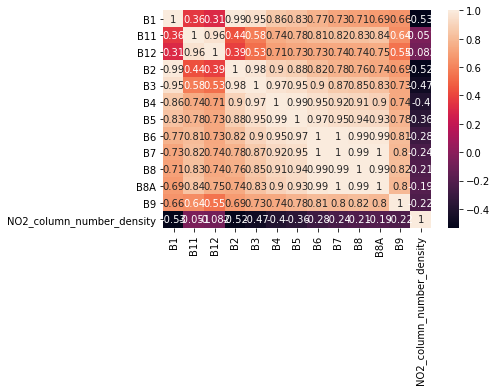

In [255]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

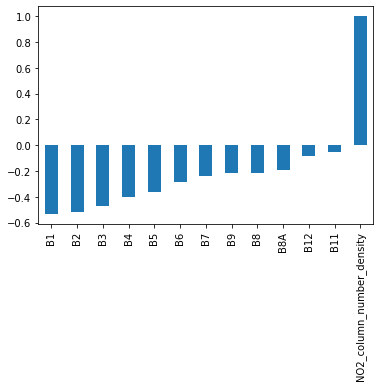

In [256]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

It looks like B1, B2, B3, B4, B10, B11, and sr-aerosol strongly correlate with the NO2 values. It will be good to see how do they perform in a fitted model.

## ! Notes to Toyon !

- Can you run a multivariate regression model for this data, and document p-values?
- Can you run a machine learning model (e.g random forest/GBM) to fit this data? Document the feature importance. You can divide the data into train and test to see how well it performs within the month. 
- Can you test it on a different month (September 2018)? To see the divergence.
- Can you try generating the similar dataset for June 2018 using Sentinel-2 and Sentinel-5P data?
- Side note: we may have to generate additional spatial and temporal values (month, day of week, etc.) in the future to develop more precise models.

In [257]:
dtale.show(df)

In [258]:
df.isnull().sum()

B1                           0
B11                          0
B12                          0
B2                           0
B3                           0
B4                           0
B5                           0
B6                           0
B7                           0
B8                           0
B8A                          0
B9                           0
NO2_column_number_density    0
dtype: int64

In [259]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [260]:
X_sep=df_sep.drop('NO2_column_number_density',axis=1).values
y_sep=df_sep['NO2_column_number_density'].values

X_train_sep, X_test_sep, y_train_sep, y_test_sep = train_test_split(X_sep, y_sep, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train_sep=scaler.fit_transform(X_train_sep)
X_test_sep=scaler.transform(X_test_sep)

In [261]:
# cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
# model = TPOTRegressor(generations=4, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=42, n_jobs=-1)
# model.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/250 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -4.728373673751096e-06


2021-06-29 02:20:04,845 - WARNING  - Code block execution exceeded 10 seconds timeout
Traceback (most recent call last):
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/stopit/utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/tpot/decorators.py", line 57, in time_limited_call
    func(*args)
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py", line 1314, in fit
    mse_paths = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 85


Generation 2 - Current best internal CV score: -4.728373673751096e-06


2021-06-29 02:22:59,159 - WARNING  - Code block execution exceeded 10 seconds timeout
Traceback (most recent call last):
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/stopit/utils.py", line 145, in wrapper
    result = func(*args, **kwargs)
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/tpot/decorators.py", line 57, in time_limited_call
    func(*args)
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X


Generation 3 - Current best internal CV score: -4.6710870783887915e-06

Generation 4 - Current best internal CV score: -4.616957189288235e-06

Best pipeline: GradientBoostingRegressor(RidgeCV(input_matrix), alpha=0.8, learning_rate=0.1, loss=lad, max_depth=6, max_features=0.8, min_samples_leaf=11, min_samples_split=14, n_estimators=100, subsample=0.8500000000000001)


TPOTRegressor(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
              generations=4, n_jobs=-1, population_size=50, random_state=42,
              scoring='neg_mean_absolute_error', verbosity=2)

## Best pipeline: GradientBoostingRegressor(RidgeCV(input_matrix), alpha=0.8, learning_rate=0.1, loss=lad, max_depth=6, max_features=0.8, min_samples_leaf=11, min_samples_split=14, n_estimators=100, subsample=0.8500000000000001)
## TPOTRegressor(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
              generations=4, n_jobs=-1, population_size=50, random_state=42,
              scoring='neg_mean_absolute_error', verbosity=2)

In [262]:
#model.export('NO2_Prediction_KR_Toyon_July_September_S2_S5_Los_Angeles_tpot_best_model.py')

In [263]:
model= GradientBoostingRegressor(alpha=0.8, learning_rate=0.1, loss="lad", max_depth=6, max_features=0.8, min_samples_leaf=11, min_samples_split=14, n_estimators=100, subsample=0.8500000000000001)
model.fit(X_train, y_train)
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))  

Training Accuracy : 0.574
Test Accuracy : 0.270


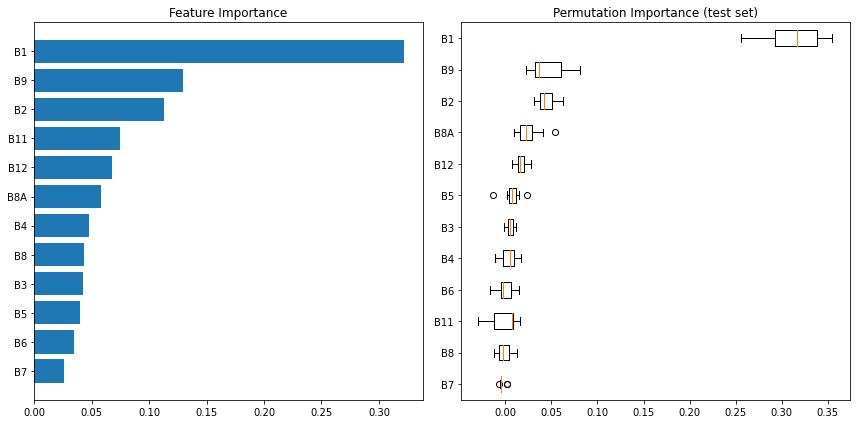

In [264]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.title('Feature Importance')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(df.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Mean Squared Error = 1.2237460382638118e-10
Mean absolute percentage error = 0.06062199061842952


Text(0, 0.5, 'NO2_column_number_density')

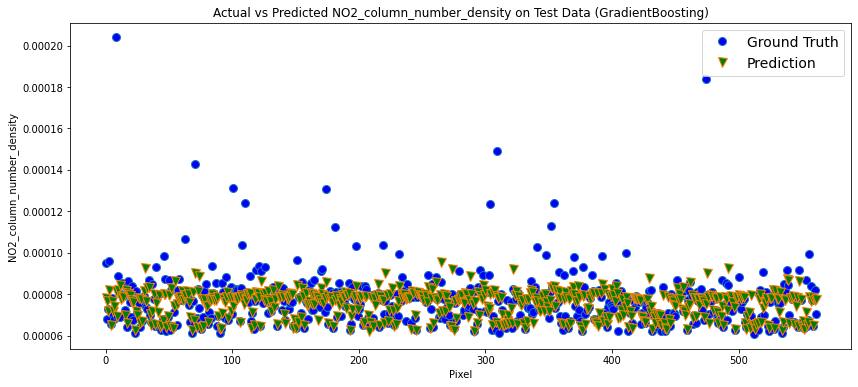

In [265]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Ground Truth')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (GradientBoosting)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Mean Squared Error = 1.36645754188332e-10
Mean absolute percentage error = 0.06895592632045836


Text(0, 0.5, 'NO2_column_number_density')

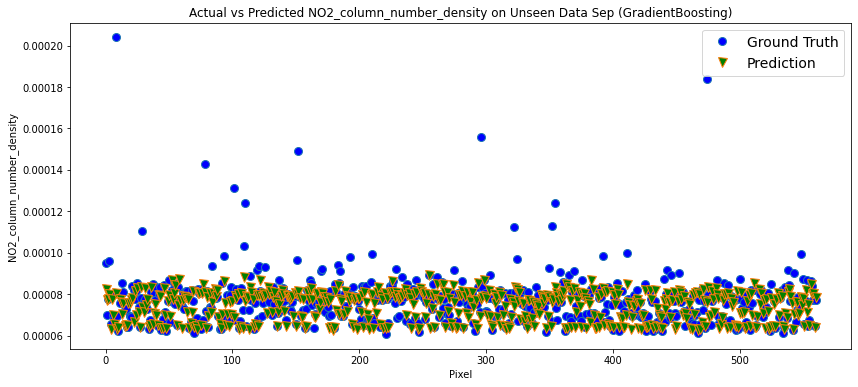

In [266]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Ground Truth')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (GradientBoosting)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Text(0, 0.5, 'NO2_column_number_density')

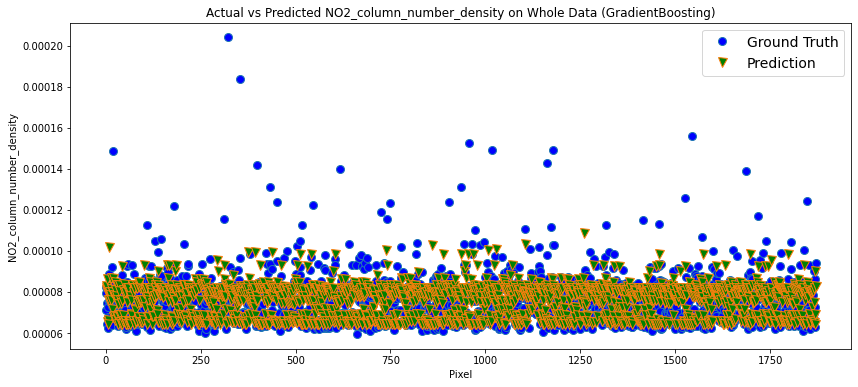

In [267]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Ground Truth')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (GradientBoosting)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

## Additional Methods follows below

In [212]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params' : {
            'C': [10,20,50],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [5,10,15]
        }
    },
}

In [213]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

,model,best_score,best_params
0,svm,-20.660752,"{'C': 10, 'kernel': 'rbf'}"
1,random_forest,0.420807,{'n_estimators': 15}


In [214]:
#Rainforest Regression
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=15)
model.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=15)

In [215]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.635
Test Accuracy : 0.304


Mean Squared Error = 1.1669824784940463e-10
Mean absolute percentage error = 0.07406532292490554


Text(0, 0.5, 'NO2_column_number_density')

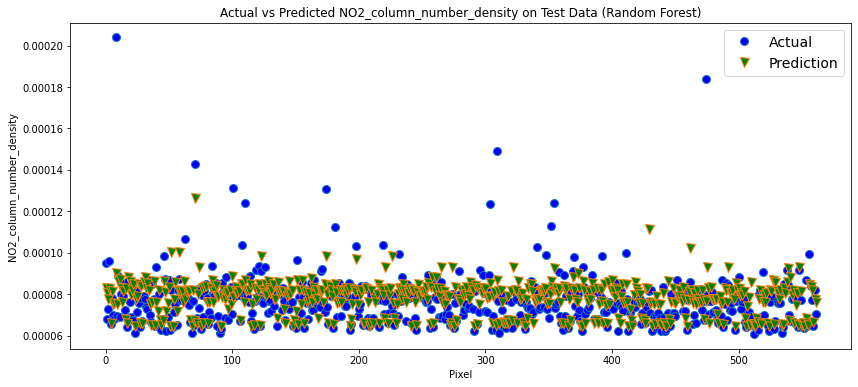

In [216]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Mean Squared Error = 1.3859619151101034e-10
Mean absolute percentage error = 0.08025177870047949


Text(0, 0.5, 'NO2_column_number_density')

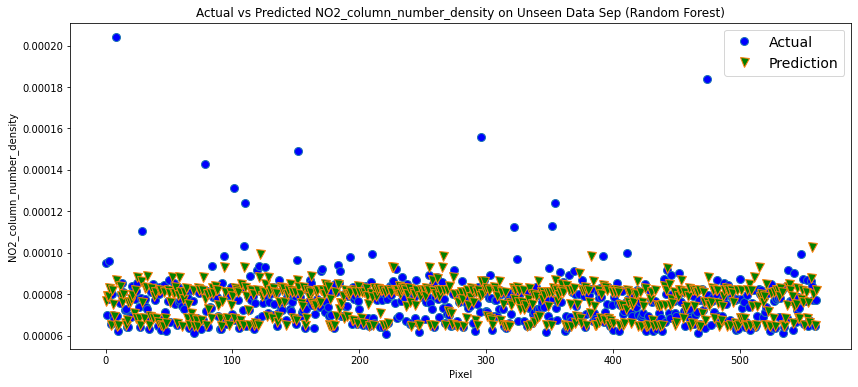

In [217]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [218]:
NO2_column_number_density=df['NO2_column_number_density']

In [219]:
X_all=scaler.transform(X)
all_prediction=model.predict(X_all)

Text(0, 0.5, 'NO2_column_number_density')

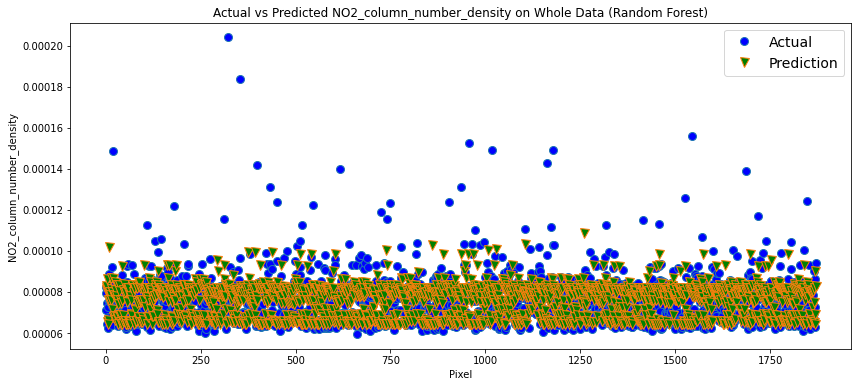

In [220]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [221]:
#X.rename(index={0: "B1", 1: "B10", 2: "B11", 3: "B2",4: "B3", 5: "B4", 6: "B5", 7: "B6", 8: "B7"})

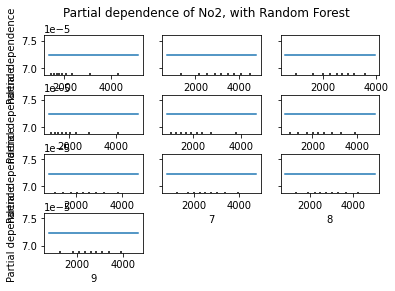

In [222]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,3,4,5,6,7,8,9])

display.figure_.suptitle('Partial dependence of No2, with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

In [223]:
logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              1289.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        15:01:15   Log-Likelihood:                          12214.
No. Observations:                1309   AIC:                                 -2.440e+04
Df Residuals:                    1297   BIC:                                 -2.434e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Start Multi-OutPut Regression Here! 
## With Target Output  
## y=  ['NO2_column_number_density','tropospheric_NO2_column_number_density']

In [224]:
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density','tropospheric_NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")

In [225]:
ground_truth= image_S2_SR.addBands(image_S5P)

In [226]:
# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 10,
    'numPixels': 2000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [227]:
print(points.size().getInfo())

1871


In [228]:
print(points.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-116.1485515151798, 34.956944219057725]}, 'id': '0', 'properties': {'B1': 1997, 'B11': 3690, 'B12': 3251, 'B2': 2010, 'B3': 2289, 'B4': 2849, 'B5': 2847, 'B6': 2921, 'B7': 3152, 'B8': 2994, 'B8A': 3266, 'B9': 601, 'NO2_column_number_density': 7.925250951512328e-05, 'tropospheric_NO2_column_number_density': 2.2330710635287687e-05}}


In [229]:
df = geemap.ee_to_pandas(points)
df

,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,NO2_column_number_density,tropospheric_NO2_column_number_density
0,1997.0,3690.0,3251.0,2010.0,2289.0,2849.0,2847.0,2921.0,3152.0,2994.0,3266.0,601.0,0.000079,0.000022
1,1632.0,3718.0,2863.5,1614.0,1698.5,2192.5,2183.0,2517.5,2758.0,2763.5,3039.0,1058.5,0.000071,0.000022
2,1785.0,4014.0,3372.0,1650.0,1770.0,2420.0,2495.0,2632.0,2992.0,2785.0,3283.0,565.0,0.000082,0.000029
3,1278.0,1689.5,1274.5,1129.5,1127.5,1158.0,1355.0,1714.0,1965.0,1886.5,2117.0,557.0,0.000075,0.000021
4,4248.0,3540.0,2869.0,3963.0,3606.0,3663.0,3541.0,3622.0,3790.0,3502.0,3911.0,864.0,0.000064,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,1733.0,4325.0,2987.0,1664.0,1725.0,2281.0,2378.0,2603.0,2885.0,2850.0,3317.0,710.0,0.000090,0.000035
1867,4333.0,3890.0,3004.0,4085.0,3807.0,3948.0,3795.0,3874.0,4115.0,3813.0,4253.0,1088.0,0.000063,0.000013
1868,1368.0,2444.0,1534.0,1163.0,1155.0,1153.0,1439.0,2940.0,3531.0,3247.0,3819.0,541.0,0.000086,0.000031
1869,2224.5,1667.0,1388.5,1995.0,1663.5,1593.0,1516.5,1538.0,1619.0,1452.5,1629.0,391.5,0.000073,0.000020


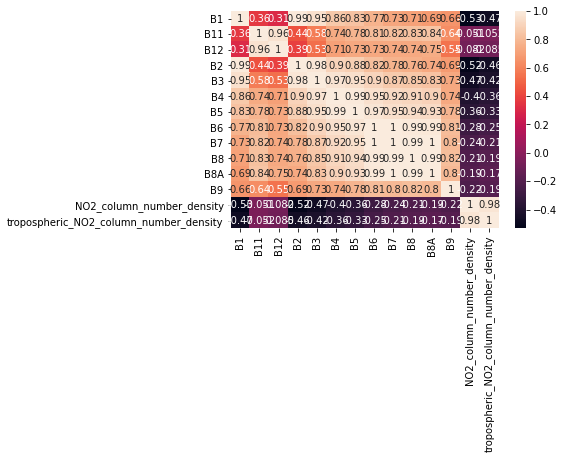

In [230]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

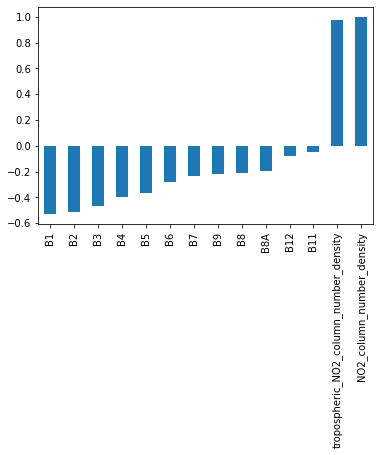

In [231]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

In [232]:
X=df.drop(['NO2_column_number_density','tropospheric_NO2_column_number_density'],axis=1).values
y=df[['NO2_column_number_density','tropospheric_NO2_column_number_density']].values


In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Linear Regression for Multioutput Regression

8.184223205240521e-05
Mean Squared Error = 1.1998832638907357e-10
Mean absolute percentage error = 0.06872542612038766
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              1289.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        15:04:08   Log-Likelihood:                          12214.
No. Observations:                1309   AIC:                                 -2.440e+04
Df Residuals:                    1297   BIC:                                 -2.434e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
 

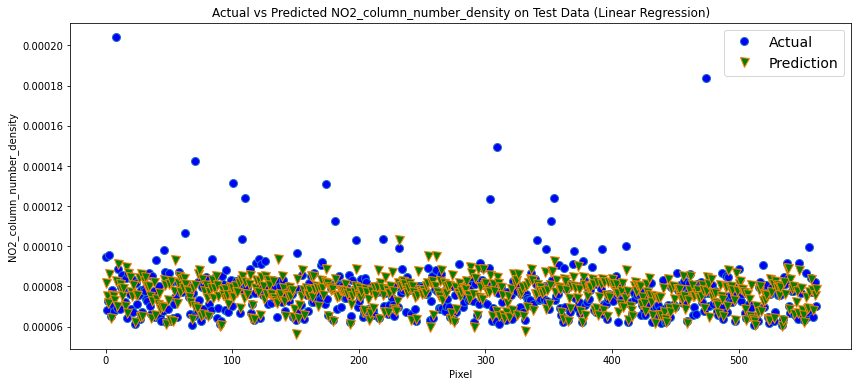

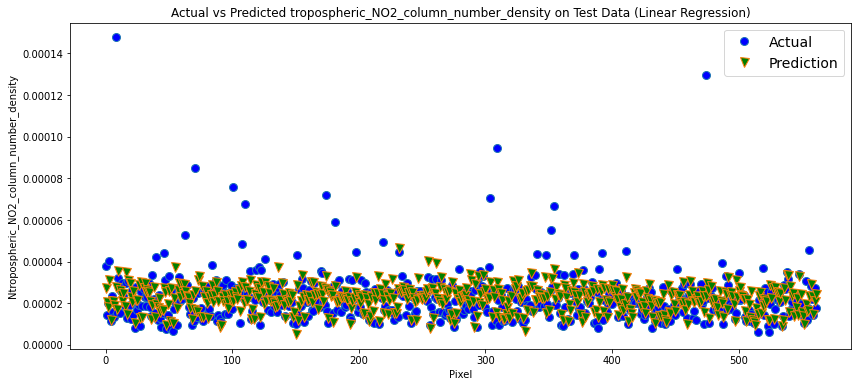

In [234]:
# defining LinearRegression model
model = LinearRegression()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

##
MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,1],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,1],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted tropospheric_NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('Ntropospheric_NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [235]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.402
Test Accuracy : 0.255


# k-Nearest Neighbors for Multioutput Regression

7.599100579150264e-05
Mean Squared Error = 1.1595677569636117e-10
Mean absolute percentage error = 0.06389006608380791
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              1289.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        15:04:09   Log-Likelihood:                          12214.
No. Observations:                1309   AIC:                                 -2.440e+04
Df Residuals:                    1297   BIC:                                 -2.434e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
 

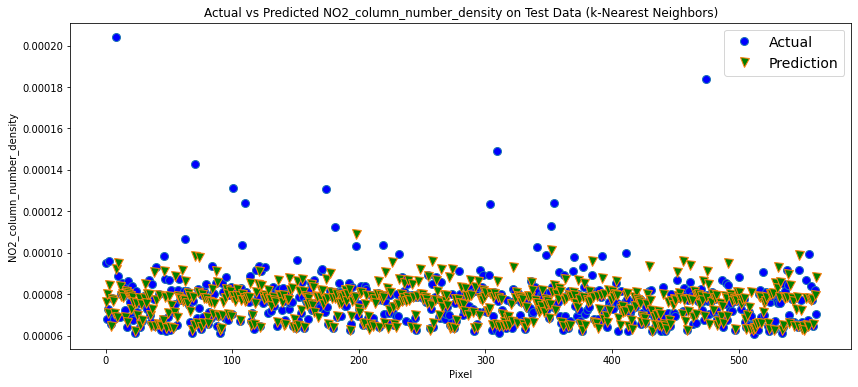

In [236]:
# define model
model = KNeighborsRegressor()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (k-Nearest Neighbors)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [237]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.590
Test Accuracy : 0.276


# Decision Tree for Multioutput Regression

7.921481283448966e-05
Mean Squared Error = 1.2537815575277583e-10
Mean absolute percentage error = 0.06723196114005758
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              1289.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        15:04:09   Log-Likelihood:                          12214.
No. Observations:                1309   AIC:                                 -2.440e+04
Df Residuals:                    1297   BIC:                                 -2.434e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
 

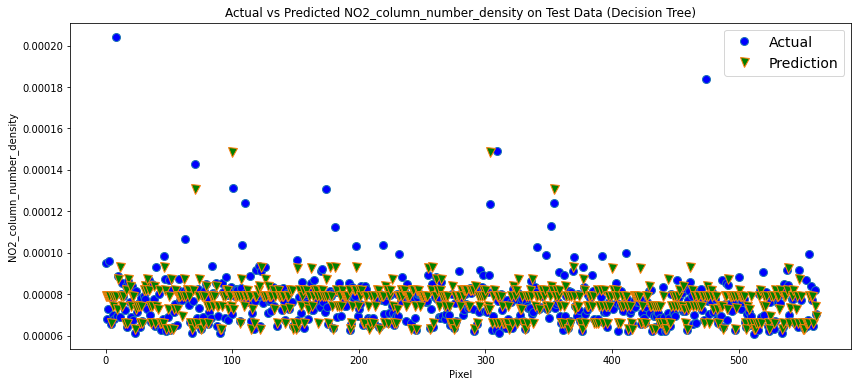

In [238]:
# define model
model = DecisionTreeRegressor(max_depth=8,
                           min_samples_split=5,
                           max_leaf_nodes=20)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [239]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.580
Test Accuracy : 0.222


Mean Squared Error = 2.1671057479297137e-11
Mean absolute percentage error = 0.026035209554812443
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              3180.
Date:                Mon, 28 Jun 2021   Prob (F-statistic):                        0.00
Time:                        15:04:11   Log-Likelihood:                          12826.
No. Observations:                1309   AIC:                                 -2.563e+04
Df Residuals:                    1296   BIC:                                 -2.556e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef 

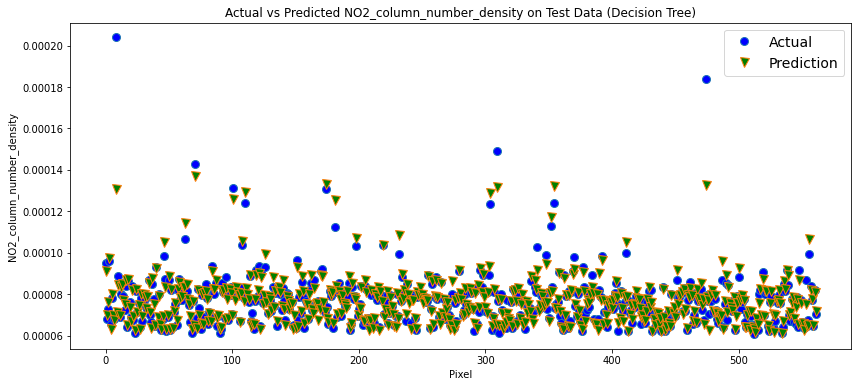

In [240]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

model = GradientBoostingRegressor(alpha=0.85, learning_rate=0.5, loss='lad', max_depth=15, max_features=0.9500000000000001,
                                min_samples_leaf=12, min_samples_split=7, n_estimators=100, subsample=0.6500000000000001)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))